In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [3]:
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import autoencoder
from AdvancedAutoencoder import AdvancedAutoencoder
from networks import WMAutoencoder, WM_VAE, VisionModel

from dataset_preprocessing import MineRlSequenceDataset

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [7]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
#     env.render()
    print(env.step(env.action_space.sample()))# take a random action
env.close()

(array([-2.07238464e-02,  1.74380471e-01, -2.30846640e-04, -2.97051743e-01]), 1.0, False, {})
(array([-0.01723624,  0.36950571, -0.00617188, -0.58980747]), 1.0, False, {})
(array([-0.00984612,  0.17447072, -0.01796803, -0.29907507]), 1.0, False, {})
(array([-0.00635671,  0.36984412, -0.02394953, -0.59737019]), 1.0, False, {})
(array([ 0.00104017,  0.56529288, -0.03589694, -0.89749973]), 1.0, False, {})
(array([ 0.01234603,  0.37067543, -0.05384693, -0.61631307]), 1.0, False, {})
(array([ 0.01975954,  0.56650669, -0.06617319, -0.92545754]), 1.0, False, {})
(array([ 0.03108967,  0.37233786, -0.08468234, -0.65428247]), 1.0, False, {})
(array([ 0.03853643,  0.56853045, -0.09776799, -0.97238367]), 1.0, False, {})
(array([ 0.04990704,  0.37484671, -0.11721567, -0.71194347]), 1.0, False, {})
(array([ 0.05740397,  0.57137984, -0.13145453, -1.03910283]), 1.0, False, {})
(array([ 0.06883157,  0.76798017, -0.15223659, -1.36999543]), 1.0, False, {})
(array([ 0.08419117,  0.57505489, -0.1796365 , -

(array([  31.18019517,    3.72222452, -105.16172462,   -9.4182168 ]), 0.0, True, {'TimeLimit.truncated': False})
(array([  31.25463966,    3.62181725, -105.35008895,   -9.13747638]), 0.0, True, {'TimeLimit.truncated': False})
(array([  31.327076  ,    3.87788923, -105.53283848,   -8.88606945]), 0.0, True, {'TimeLimit.truncated': False})
(array([  31.40463379,    4.12622812, -105.71055987,   -8.71063805]), 0.0, True, {'TimeLimit.truncated': False})
(array([  31.48715835,    3.99885963, -105.88477263,   -8.36209707]), 0.0, True, {'TimeLimit.truncated': False})
(array([  31.56713554,    4.23086787, -106.05201457,   -8.33475747]), 0.0, True, {'TimeLimit.truncated': False})
(array([  31.6517529 ,    4.08061983, -106.21870972,   -7.96873409]), 0.0, True, {'TimeLimit.truncated': False})
(array([  31.73336529,    3.91734393, -106.3780844 ,   -7.60107273]), 0.0, True, {'TimeLimit.truncated': False})
(array([  31.81171217,    4.1280331 , -106.53010586,   -7.76335341]), 0.0, True, {'TimeLimit.tru

In [8]:
from gym.envs.box2d.car_racing import CarRacing

ModuleNotFoundError: No module named 'Box2D'

In [9]:
import highway_env

In [14]:
import os
os.environ["SDL_VIDEODRIVER"] = "directfb"

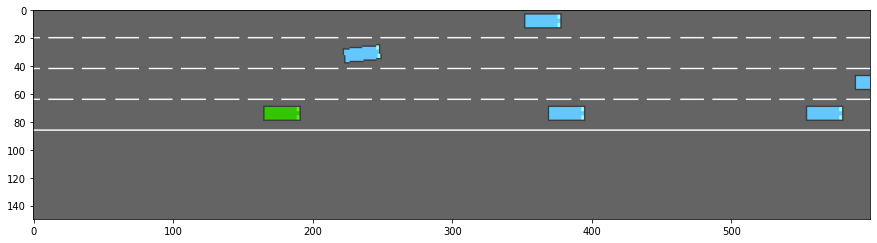

In [15]:
env = gym.make('highway-v0')
env.reset()
for _ in range(3):
    action = env.action_type.actions_indexes["IDLE"]
    obs, reward, done, info = env.step(action)
#     env.render()

plt.imshow(env.render(mode="rgb_array"))
plt.show()

In [16]:
env.config

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

In [31]:
env = gym.make("parking-v0")

In [32]:
env.config

{'observation': {'type': 'KinematicsGoal',
  'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
  'scales': [100, 100, 5, 5, 1, 1],
  'normalize': False},
 'action': {'type': 'ContinuousAction'},
 'simulation_frequency': 15,
 'policy_frequency': 5,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 300,
 'centering_position': [0.5, 0.5],
 'scaling': 7,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02],
 'success_goal_reward': 0.12,
 'collision_reward': -5,
 'steering_range': 0.7853981633974483,
 'duration': 100,
 'controlled_vehicles': 1}

In [35]:
env.reset()

{'observation': array([ 0.        ,  0.        , -0.        , -0.        , -0.9989822 ,
        -0.04510606]),
 'achieved_goal': array([ 0.        ,  0.        , -0.        , -0.        , -0.9989822 ,
        -0.04510606]),
 'desired_goal': array([2.000000e-02, 1.400000e-01, 0.000000e+00, 0.000000e+00,
        6.123234e-17, 1.000000e+00])}

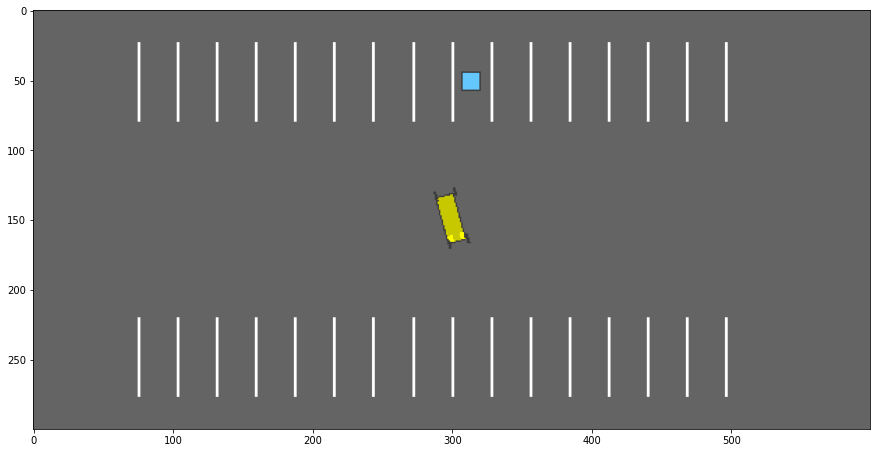

In [34]:
plt.imshow(env.render(mode="rgb_array"))
plt.show()

In [38]:
obs, reward, done, metrics = env.step((1.0, 0.5))

In [39]:
obs

{'observation': array([-3.22161314e-03, -8.55487750e-04, -3.98958988e-01, -2.88396620e-02,
        -9.97397469e-01, -7.20991551e-02]),
 'achieved_goal': array([-3.22161314e-03, -8.55487750e-04, -3.98958988e-01, -2.88396620e-02,
        -9.97397469e-01, -7.20991551e-02]),
 'desired_goal': array([2.000000e-02, 1.400000e-01, 0.000000e+00, 0.000000e+00,
        6.123234e-17, 1.000000e+00])}

In [40]:
reward

-0.32690700812069606

In [41]:
done

False

In [42]:
metrics

{'speed': 1.9999999999999998,
 'crashed': False,
 'action': (1.0, 0.5),
 'is_success': False}

In [43]:
env.config

{'observation': {'type': 'KinematicsGoal',
  'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
  'scales': [100, 100, 5, 5, 1, 1],
  'normalize': False},
 'action': {'type': 'ContinuousAction'},
 'simulation_frequency': 15,
 'policy_frequency': 5,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 300,
 'centering_position': [0.5, 0.5],
 'scaling': 7,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02],
 'success_goal_reward': 0.12,
 'collision_reward': -5,
 'steering_range': 0.7853981633974483,
 'duration': 100,
 'controlled_vehicles': 1}

In [46]:
class QNet(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=20):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, out_size),
        )
    
    def forward(self, input):
        return self.hidden(input)

In [52]:
class PNet(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=20):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, out_size),
            nn.Tanh(),
        )
    
    def forward(self, input):
        return self.hidden(input)

In [53]:
qn = QNet(6 + 6 + 2, 1)

In [54]:
pn = PNet(6 + 6, 2)

In [61]:
s = torch.tensor(np.concatenate((obs['observation'], obs['desired_goal'])), dtype=torch.float32)

In [62]:
a = pn(s)

In [63]:
a

tensor([-0.0408,  0.0391], grad_fn=<TanhBackward>)

In [66]:
q = qn(torch.cat((s, a)))

In [67]:
q

tensor([0.1009], grad_fn=<AddBackward0>)